In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
df = pd.read_csv("gold.csv")
df.head(2)

,3M Libor_T-1,EM Bond_T-1,US Bond ETF_T-1,Wheat 1_T-1,Wheat 2_T-1,Crude Palm Oil_T-1,Brent 1_T-1,Brent 2_T-1,Light Crude_T-1,White Sugar_T-1,...,MSCI EM_T-22,Shanghai Index_T-22,Nikkei Ind_T-22,MSCI APAC ex J_T-22,EMEquity ETF_T-22,Silver_T-22,Platinum_T-22,Palladium_T-22,Gold_T-22,Gold_T+22
0,0.000000,0.000879,0.001050,0.013158,0.013562,0.003163,-0.007879,-0.004945,-0.003486,-0.024706,...,-0.009862,0.073090,-0.028816,-0.001613,-0.012274,-0.025210,0.024300,0.082695,0.053534,0.004648
1,-0.004587,0.004096,0.002383,0.043599,0.041035,0.040991,0.042356,0.039759,0.029667,0.047906,...,0.006801,0.099088,-0.043704,0.007670,0.018151,0.060624,0.068595,0.151468,0.085822,-0.002105


In [ ]:
# Пропусков нет
df.columns[df.isna().sum()!=0]

Index([], dtype='object')

In [ ]:
class GoldDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
batch_size = 64
target = "Gold_T+22"
X = df.drop(columns=target)
y = df[[target]]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2)
traindataset = GoldDataset(X_train, y_train)
trainloader = DataLoader(traindataset, batch_size=batch_size)
testdataset = GoldDataset(X_test, y_test)
testloader = DataLoader(testdataset, batch_size=batch_size)

In [ ]:
X.shape, y.shape

((2558, 120), (2558, 1))

In [ ]:
in_features = X.shape[1]
hidden_size = 1000
model = torch.nn.Sequential(
    nn.Linear(in_features, hidden_size),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(hidden_size,1),
)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
n_epochs = 500
step  = 50
results = np.zeros((4, n_epochs))

for epoch in range(n_epochs):
    y_pred = torch.empty(0).float()
    y_true = torch.empty(0).float()
    model.train()
    for curr_x, curr_y in trainloader:
        optimizer.zero_grad()
        outputs = model(curr_x)
        loss = criterion(outputs, curr_y)
        loss.backward()
        optimizer.step()
        y_true = torch.cat((y_true, curr_y))
        y_pred = torch.cat((y_pred, outputs))

    train_r2 = r2_score(y_true.detach(), y_pred.detach()).item()
    train_loss = criterion(y_pred.detach(), y_true.detach()).item()

    model.eval()
    with torch.no_grad():
        y_pred = torch.empty(0).float()
        y_true = torch.empty(0).float()
        for curr_x, curr_y in testloader:
            outputs = model(curr_x)
            y_true = torch.cat((y_true, curr_y))
            y_pred = torch.cat((y_pred, outputs))
        test_r2 = r2_score(y_true.detach(), y_pred.detach()).item()
        test_loss = criterion(y_pred.detach(), y_true.detach()).item()
        if epoch % step == 0:
            print(f'#{epoch:4d} train loss: {train_loss:6.4f} test loss: {test_loss:6.4f} train r2: {train_r2:6.4f} test r2: {test_r2:6.4f}')
        results[:, epoch] = train_loss, test_loss, train_r2, test_r2

#   0 train loss: 0.0026 test loss: 0.0020 train r2: -0.2171 test r2: -0.0549
#  50 train loss: 0.0012 test loss: 0.0015 train r2: 0.4444 test r2: 0.2120
# 100 train loss: 0.0006 test loss: 0.0013 train r2: 0.7022 test r2: 0.3102
# 150 train loss: 0.0004 test loss: 0.0012 train r2: 0.8048 test r2: 0.3608
# 200 train loss: 0.0003 test loss: 0.0012 train r2: 0.8658 test r2: 0.3714
# 250 train loss: 0.0002 test loss: 0.0012 train r2: 0.8972 test r2: 0.3906
# 300 train loss: 0.0002 test loss: 0.0011 train r2: 0.9082 test r2: 0.4046
# 350 train loss: 0.0002 test loss: 0.0011 train r2: 0.9277 test r2: 0.4039
# 400 train loss: 0.0001 test loss: 0.0011 train r2: 0.9311 test r2: 0.4069
# 450 train loss: 0.0001 test loss: 0.0011 train r2: 0.9449 test r2: 0.4133


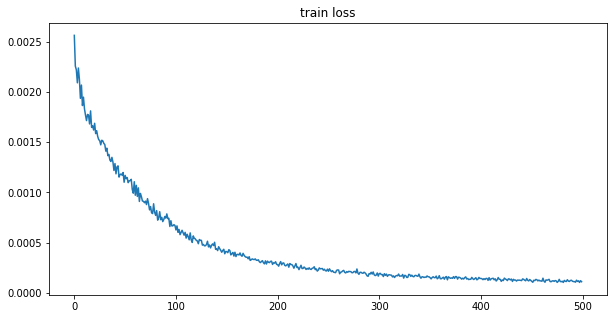

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("train loss")
plt.plot(range(results.shape[1]), results[0]);

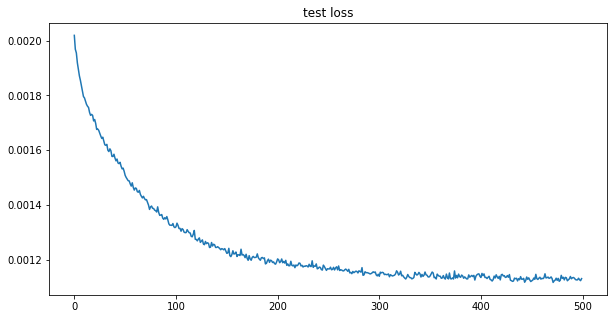

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("test loss")
plt.plot(range(results.shape[1]), results[1]);

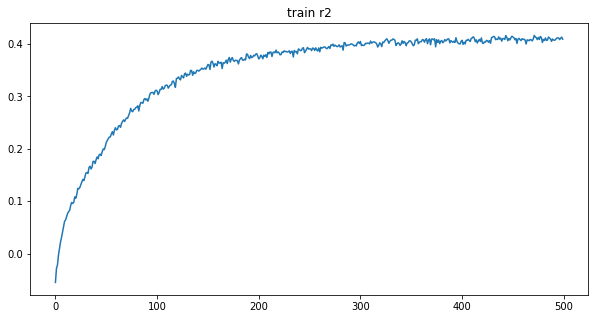

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("train r2")
plt.plot(range(results.shape[1]), results[3]);

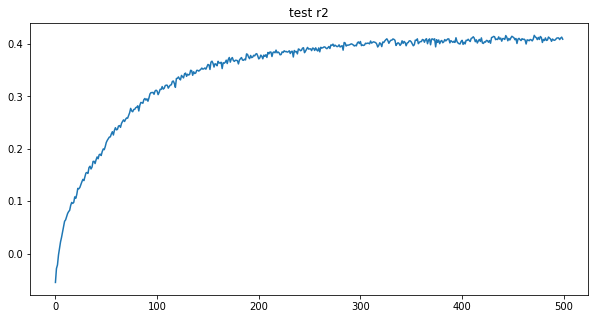

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("test r2")
plt.plot(range(results.shape[1]), results[3]);

In [ ]:
model.eval()
with torch.no_grad():
    y_pred = torch.empty(0).float()
    y_true = torch.empty(0).float()
    for curr_x, curr_y in testloader:
        outputs = model(curr_x)
        y_true = torch.cat((y_true, curr_y))
        y_pred = torch.cat((y_pred, outputs))
    test_r2 = r2_score(y_true.detach(), y_pred.detach()).item()
    test_loss = criterion(y_pred.detach(), y_true.detach()).item()
print(f"r2 на тестовом {test_r2:.4f} функция ошибки на тестовом {test_loss:.4f}")

r2 на тестовом 0.4091 функция ошибки на тестовом 0.0011
